<a href="https://colab.research.google.com/github/amalmon/Book-recommendation-system/blob/main/Book_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys. In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).
Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

Content
The Book-Crossing dataset comprises 3 files.

● Users

Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.


● Books

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.


● Ratings

Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0.

In [83]:
import numpy as np
import pandas as pd

In [84]:
import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [85]:
books=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Books.csv")
users=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Users.csv")
ratings=pd.read_csv("/content/drive/MyDrive/Almabetter/capstone projects/CAPSTONE-PROJECT-4-RECOMMENDATION SYSTEM/Ratings.csv")

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**fetching basic idea about data set by first 5 entries**

In [86]:
#head of book data set
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [87]:
#head of users data set
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [88]:
#head of rating data set
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


**figure out structure of data sets**

In [89]:
#for printing shape of all data set
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


**Searching for null values of data sets (if there any)**

In [90]:
#for total of null values in books data set
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [91]:
#for total of null values in users data set
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64



*   Basically, missing values of age column will not much more affect on our final aim recommendation




In [92]:
#for total of null values in ratings data set
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

**finding any duplicate entries are there**

In [93]:
#tot. of duplicate entries in books
books.duplicated().sum()

0

In [94]:
#tot. of duplicate entries in users
users.duplicated().sum()

0

In [95]:
#tot. of duplicate entries in ratings
ratings.duplicated().sum()

0

In [96]:
books.Publisher.unique().size

16808

In [97]:
books['Year-Of-Publication'].unique().size

202

In [98]:
books['Book-Title'].unique().size

242135

In [99]:
books['Book-Author'].unique().size

102024

In [100]:
users.Location.unique().size

57339

### **Pre processing of datasets**



*  dropping Null value entries, as a best option for recommendation system.and also there is no possibility to fill with approximate values or it is not much worth here.
*  dropping 2 of 3 image url columns and holding large image url column
*  dropping user id column which is not needed



In [101]:
#droping null values of books dataset
books.dropna(inplace=True)

In [102]:
#droping columns 'Image-URL-S','Image-URL-M'
books.drop(columns=['Image-URL-S','Image-URL-M'],inplace=True)

In [103]:
books.shape

(271354, 6)

In [104]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271354 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271354 non-null  object
 1   Book-Title           271354 non-null  object
 2   Book-Author          271354 non-null  object
 3   Year-Of-Publication  271354 non-null  object
 4   Publisher            271354 non-null  object
 5   Image-URL-L          271354 non-null  object
dtypes: object(6)
memory usage: 14.5+ MB


In [105]:
# merging rating dataset and books dataset
books_with_rating=ratings.merge(books,on='ISBN')

In [106]:
books_with_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...,...,...,...
1031124,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995,Random House Value Pub,http://images.amazon.com/images/P/0517145553.0...
1031125,276688,1575660792,7,Gray Matter,Shirley Kennett,1996,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575660792.0...
1031126,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,Debbie Dadey,1997,Apple,http://images.amazon.com/images/P/0590907301.0...
1031127,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),Judith Freeman,1997,Vintage Books USA,http://images.amazon.com/images/P/0679752714.0...


1.   need to create a avrg. rating column
2.   create no. of rating column

In [107]:
#making avrg_rating df
avrg_df=books_with_rating.groupby('ISBN')['Book-Rating'].mean().reset_index()
avrg_df.columns=['ISBN','Avg.Rating']

In [108]:
avrg_df

,ISBN,Avg.Rating
0,0000913154,8.0
1,0001010565,0.0
2,0001046438,9.0
3,0001046713,0.0
4,000104687X,6.0
...,...,...
270140,B000234N76,0.0
270141,B000234NC6,0.0
270142,B00029DGGO,0.0
270143,B0002JV9PY,0.0


In [109]:
#merging avrg_df and Book_with_rating
books_with_rating=avrg_df.merge(books_with_rating,on='ISBN')

In [110]:
books_with_rating

,ISBN,Avg.Rating,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0000913154,8.0,171118,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...
1,0001010565,0.0,86123,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...
2,0001010565,0.0,209516,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...
3,0001046438,9.0,23902,9,Liar,Stephen Fry,0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...
4,0001046713,0.0,196149,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...
...,...,...,...,...,...,...,...,...,...
1031124,B000234N76,0.0,264317,0,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...
1031125,B000234NC6,0.0,100906,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...
1031126,B00029DGGO,0.0,100088,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...
1031127,B0002JV9PY,0.0,179791,0,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...


In [111]:
#making count of rating df
rating_count_df=books_with_rating['ISBN'].value_counts().reset_index()
rating_count_df.columns=['ISBN','no.of ratings']

In [112]:
rating_count_df

,ISBN,no.of ratings
0,0971880107,2502
1,0316666343,1295
2,0385504209,883
3,0060928336,732
4,0312195516,723
...,...,...
270140,0590661388,1
270141,0590662082,1
270142,059066218X,1
270143,0590664700,1


In [113]:
#merging rating_count_df with book_with_rating df
books_with_rating=rating_count_df.merge(books_with_rating,on='ISBN')

In [114]:
books_with_rating

,ISBN,no.of ratings,Avg.Rating,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0971880107,2502,1.019584,276925,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
1,0971880107,2502,1.019584,276939,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
2,0971880107,2502,1.019584,276954,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
3,0971880107,2502,1.019584,277042,2,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
4,0971880107,2502,1.019584,277157,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
...,...,...,...,...,...,...,...,...,...,...
1031124,0590661388,1,7.000000,14079,7,Teaching the Stories and Poems of Edgar Allan ...,Tara McCarthy,1999,Scholastic,http://images.amazon.com/images/P/0590661388.0...
1031125,0590662082,1,0.000000,278418,0,"A Bug, a Bear, and a Boy: Paint a Picture",David McPhail,1998,Scholastic SeeSaw Book Club,http://images.amazon.com/images/P/0590662082.0...
1031126,059066218X,1,0.000000,278418,0,"A Bug, a Bear, and a Boy Gof for a Ride",David McPhail,1998,Scholastic,http://images.amazon.com/images/P/059066218X.0...
1031127,0590664700,1,7.000000,102460,7,Portraits of Little Women (Amy's Story),Susan Beth Pfeffer,1997,Scholastic,http://images.amazon.com/images/P/0590664700.0...


In [115]:
books_with_rating.shape

(1031129, 10)

# **E D A**

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

**TOP 15 MOST POPULAR AUTHORS**

In [117]:
authors_value_count=books_with_rating['Book-Author'].value_counts().reset_index()
authors_value_count.columns=['Author','count']
top_author_counts=authors_value_count.sort_values('count',ascending=False)


In [118]:
top_author_counts

,Author,count
0,Stephen King,10053
1,Nora Roberts,8429
2,John Grisham,6010
3,James Patterson,5845
4,Mary Higgins Clark,4777
...,...,...
68735,Mary Jo Salter,1
68736,SILVA MEHTA,1
68737,Lucretia Stewart,1
68738,Valerian Ivanovich Albanov,1


[]

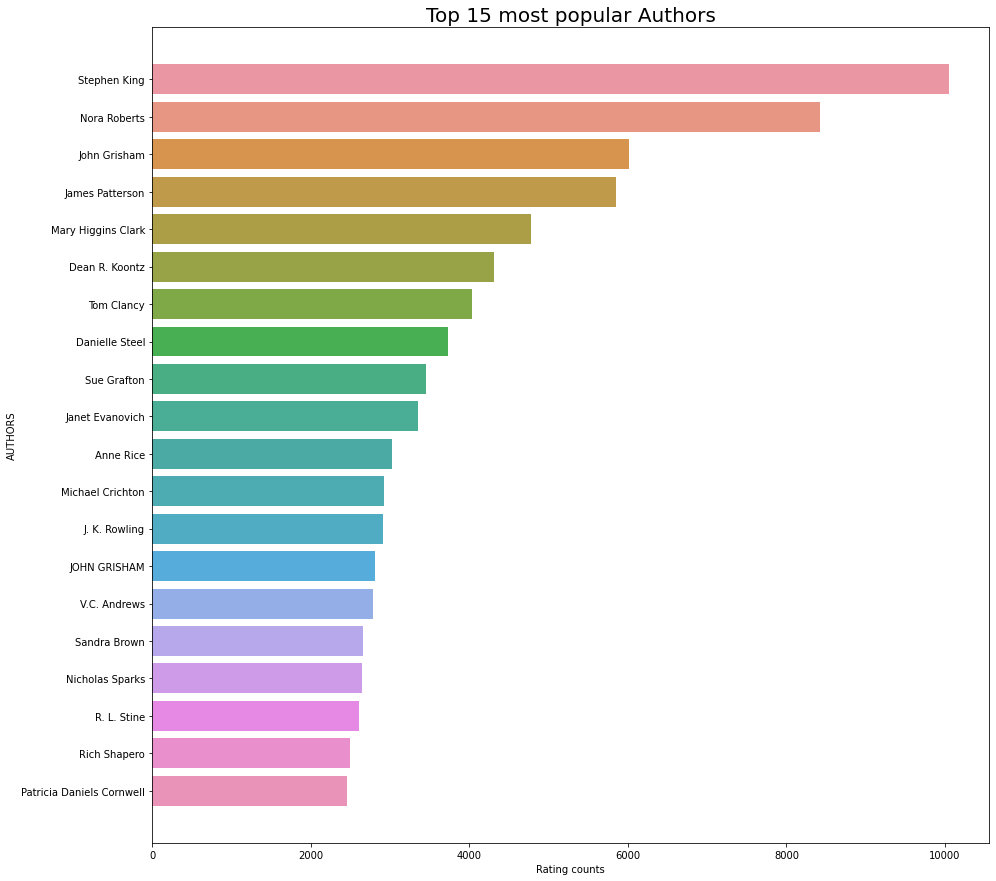

In [119]:
plt.figure(figsize=(15,15))
sns.barplot(data=top_author_counts.head(20),y='Author',x='count')
plt.ylabel('AUTHORS')
plt.xlabel('Rating counts')
plt.title('Top 15 most popular Authors',fontsize = 20)
plt.plot()

**BAR PLOT OF RATINGS**


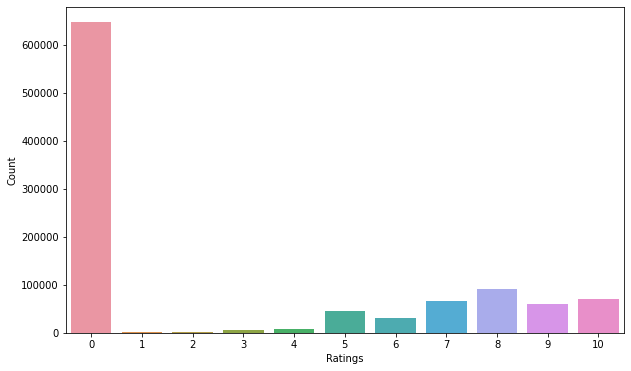

In [120]:
plt.figure(figsize=(10,6))
sns.countplot(data = books_with_rating, x = 'Book-Rating')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

**TOP 30 MOST REVIEWED/READED BOOKS**

In [121]:
most_read = books_with_rating['Book-Title'].value_counts().reset_index()
most_read.columns = ['bookTitle','count']

most_read

,bookTitle,count
0,Wild Animus,2502
1,The Lovely Bones: A Novel,1295
2,The Da Vinci Code,898
3,A Painted House,838
4,The Nanny Diaries: A Novel,828
...,...,...
241061,Why Am I Afraid to Love?: Overcoming Rejection...,1
241062,12 Stories,1
241063,You Have a Ministry,1
241064,A Divine Revelation of Heaven,1


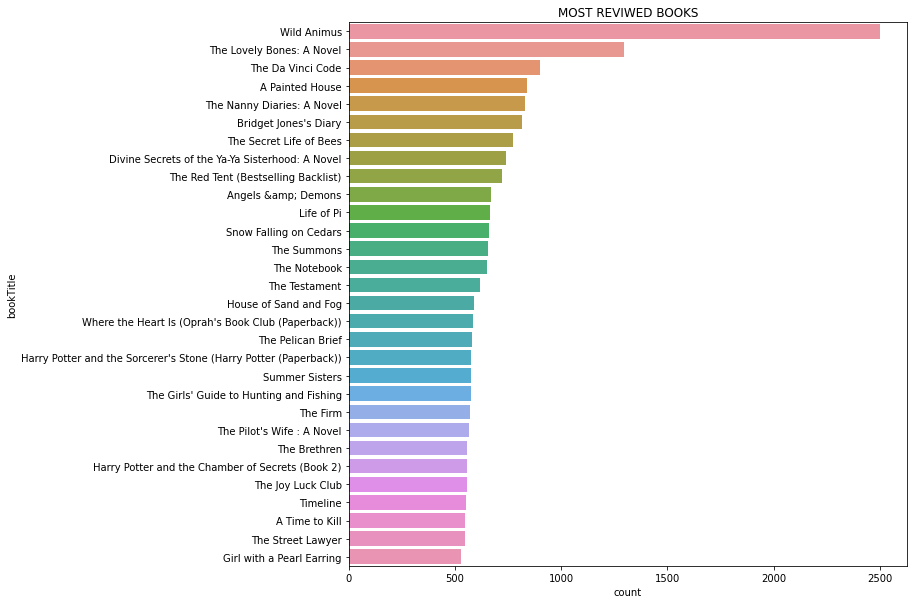

In [122]:
plt.figure(figsize = (10,10))
plt.title("MOST REVIWED BOOKS")
sns.barplot(x = 'count', y = 'bookTitle', data = most_read.head(30))

**AVERAGE RATINGS OF MOST REVIEWED BOOKS**

In [123]:
avg_rating_data = books_with_rating.groupby('Book-Title', as_index=False)['Book-Rating'].mean()
rating_count_data = books_with_rating['Book-Title'].value_counts().reset_index()
rating_count_data.columns = ['Book-Title','count']
most_rated_by_reads = pd.merge(avg_rating_data,rating_count_data,on='Book-Title')

In [124]:
most_rated_by_reads

,Book-Title,Book-Rating,count
0,A Light in the Storm: The Civil War Diary of ...,2.250000,4
1,Always Have Popsicles,0.000000,1
2,Apple Magic (The Collector's series),0.000000,1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000,1
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000,1
...,...,...,...
241061,Ã?Â?lpiraten.,0.000000,2
241062,Ã?Â?rger mit Produkt X. Roman.,5.250000,4
241063,Ã?Â?sterlich leben.,7.000000,1
241064,Ã?Â?stlich der Berge.,2.666667,3


In [125]:
most_rated_by_reads = most_rated_by_reads.sort_values('count',ascending=False)

In [126]:
most_rated_by_reads

,Book-Title,Book-Rating,count
234946,Wild Animus,1.019584,2502
196322,The Lovely Bones: A Novel,4.468726,1295
183569,The Da Vinci Code,4.642539,898
5303,A Painted House,3.231504,838
199233,The Nanny Diaries: A Novel,3.530193,828
...,...,...,...
147558,"Real Marriage Material (Silhouette Romance, No...",0.000000,1
63663,Fabulous Fragrances II : A Guide to Prestige P...,10.000000,1
147556,Real Love: The Truth About Finding Uncondition...,0.000000,1
147555,Real Love: The Drawings for Sean,10.000000,1


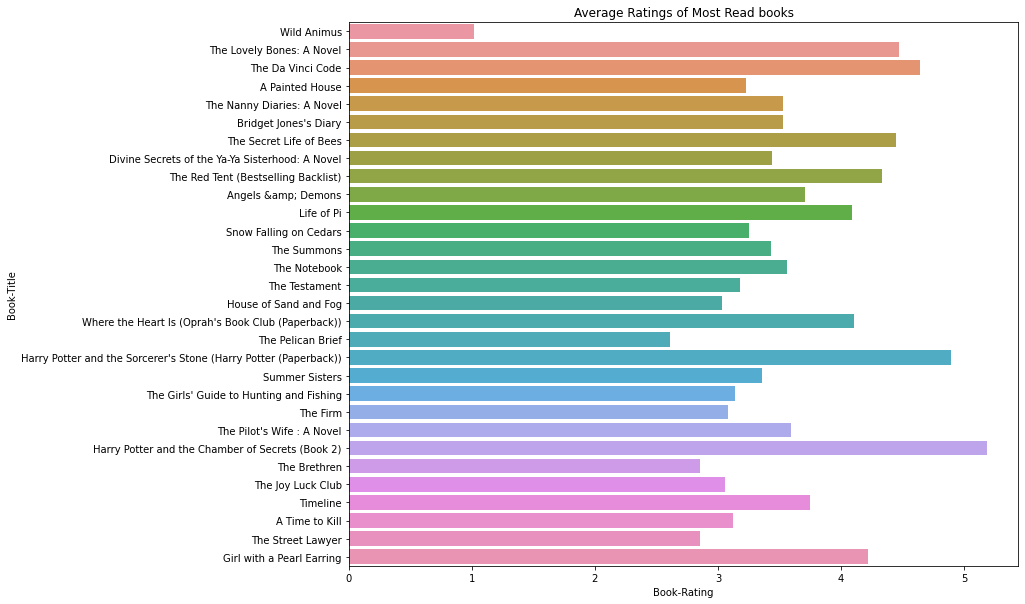

In [127]:
plt.figure(figsize=(12,10))
plt.title("Average Ratings of Most Read books")
sns.barplot(x = 'Book-Rating', y = 'Book-Title', data = most_rated_by_reads.head(30))

**TOP 30 PUBLISHERS**

In [128]:
top_publisher = books_with_rating['Publisher'].value_counts().reset_index()
top_publisher.columns = ['Publisher', 'count']
top_publisher['Publisher'] = top_publisher['Publisher']
top_publisher = top_publisher.sort_values('count',ascending=False)

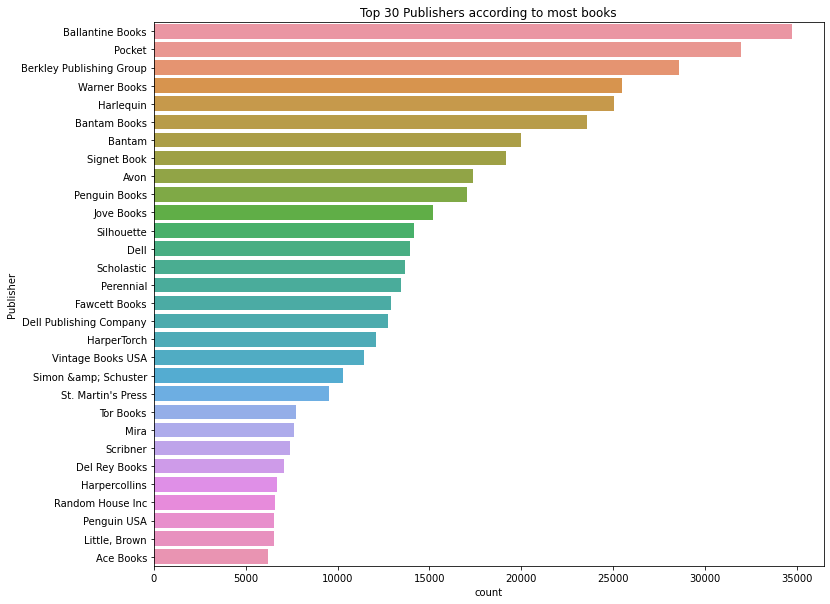

In [129]:
plt.figure(figsize=(12,10))
plt.title('Top 30 Publishers according to most books')
sns.barplot(data = top_publisher.head(30), x = 'count', y = 'Publisher')

**MOST BOOKS PUBLISHING YEAR**

In [130]:
yearOfPublication = books['Year-Of-Publication'].value_counts().reset_index()
yearOfPublication.columns = ['year', 'count']
yearOfPublication = yearOfPublication.sort_values('count',ascending=False)
yearOfPublication

,year,count
0,2002,13902
1,2001,13714
2,1999,13414
3,2000,13373
4,1998,12116
...,...,...
170,1938,1
169,2024,1
168,1926,1
167,1376,1


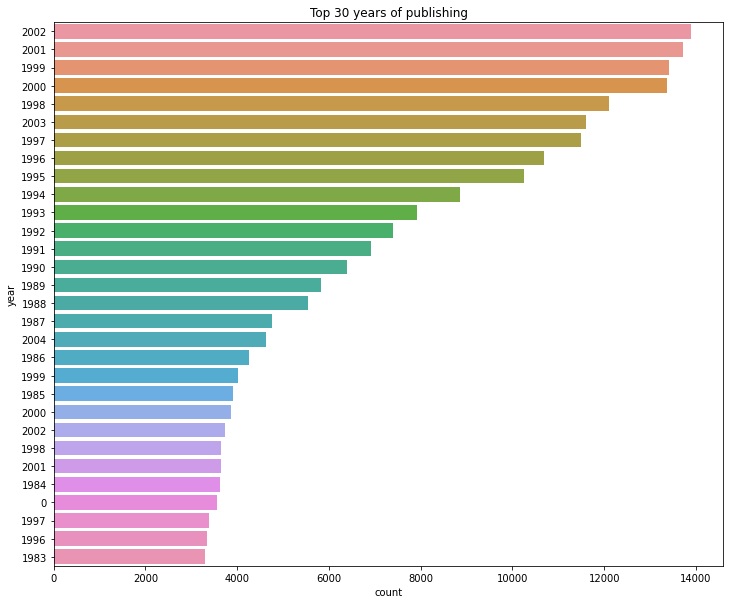

In [131]:
plt.figure(figsize=(12,10))
plt.title('Top 30 years of publishing')
sns.barplot(data = yearOfPublication.head(30), x='count', y='year')

## **POPULARITY BASED RECOMMENDATION SYSTEM**

A popularity based recommendation system is a type of recommendation system that suggests items that are popular among the user group. 

**when we have a new user, we will face cold start issue in recommendation. we can rely on a popularity based recommendation system in this scenario.**

It is based on the assumption that items that are popular among many people are more likely to be liked by the user.
   
    To implement a popularity based recommendation system, 
followed these steps:

*Collect data on the books that users have read or rated in the past.

*Calculate the popularity score for each book, using a metric such as the number of ratings or the average rating the book has received.

*Sort the books in descending order of popularity.(basically, we define popularity by number of interactions or number of ratings given to a book)

*Recommend the top books to the user, based on the average rating of popular books


In [132]:
most_read

,bookTitle,count
0,Wild Animus,2502
1,The Lovely Bones: A Novel,1295
2,The Da Vinci Code,898
3,A Painted House,838
4,The Nanny Diaries: A Novel,828
...,...,...
241061,Why Am I Afraid to Love?: Overcoming Rejection...,1
241062,12 Stories,1
241063,You Have a Ministry,1
241064,A Divine Revelation of Heaven,1


In [133]:
#recalling data frame with book name avrg rating and number of rating
most_rated_by_reads

,Book-Title,Book-Rating,count
234946,Wild Animus,1.019584,2502
196322,The Lovely Bones: A Novel,4.468726,1295
183569,The Da Vinci Code,4.642539,898
5303,A Painted House,3.231504,838
199233,The Nanny Diaries: A Novel,3.530193,828
...,...,...,...
147558,"Real Marriage Material (Silhouette Romance, No...",0.000000,1
63663,Fabulous Fragrances II : A Guide to Prestige P...,10.000000,1
147556,Real Love: The Truth About Finding Uncondition...,0.000000,1
147555,Real Love: The Drawings for Sean,10.000000,1


In [134]:
#taking books only with above 250 number of rating 
popular_df=most_rated_by_reads[most_rated_by_reads['count']>=250].sort_values('Book-Rating',ascending=False) 

In [135]:
books_with_rating

,ISBN,no.of ratings,Avg.Rating,User-ID,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-L
0,0971880107,2502,1.019584,276925,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
1,0971880107,2502,1.019584,276939,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
2,0971880107,2502,1.019584,276954,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
3,0971880107,2502,1.019584,277042,2,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
4,0971880107,2502,1.019584,277157,0,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...
...,...,...,...,...,...,...,...,...,...,...
1031124,0590661388,1,7.000000,14079,7,Teaching the Stories and Poems of Edgar Allan ...,Tara McCarthy,1999,Scholastic,http://images.amazon.com/images/P/0590661388.0...
1031125,0590662082,1,0.000000,278418,0,"A Bug, a Bear, and a Boy: Paint a Picture",David McPhail,1998,Scholastic SeeSaw Book Club,http://images.amazon.com/images/P/0590662082.0...
1031126,059066218X,1,0.000000,278418,0,"A Bug, a Bear, and a Boy Gof for a Ride",David McPhail,1998,Scholastic,http://images.amazon.com/images/P/059066218X.0...
1031127,0590664700,1,7.000000,102460,7,Portraits of Little Women (Amy's Story),Susan Beth Pfeffer,1997,Scholastic,http://images.amazon.com/images/P/0590664700.0...


In [136]:
popular_df=popular_df.merge(books_with_rating,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Year-Of-Publication','no.of ratings','Avg.Rating','Image-URL-L',]]

In [162]:
popular_df.head(15)

,Book-Title,Book-Author,Year-Of-Publication,no.of ratings,Avg.Rating,Image-URL-L
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,226,5.345133,http://images.amazon.com/images/P/0439136369.0...
428,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,194,6.541237,http://images.amazon.com/images/P/0439139597.0...
815,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,168,6.363095,http://images.amazon.com/images/P/0590353403.0...
1093,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,334,5.571856,http://images.amazon.com/images/P/043935806X.0...
1440,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,351,4.729345,http://images.amazon.com/images/P/0439064872.0...
1996,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,1986,281,5.007117,http://images.amazon.com/images/P/0345339681.0...
2277,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,1986,257,4.505837,http://images.amazon.com/images/P/0345339703.0...
2645,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,571,4.900175,http://images.amazon.com/images/P/059035342X.0...
3220,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,177,4.276836,http://images.amazon.com/images/P/0345339711.0...
3480,To Kill a Mockingbird,Harper Lee,1988,389,4.920308,http://images.amazon.com/images/P/0446310786.0...


In [138]:
popular_df['Image-URL-L'][0]

'http://images.amazon.com/images/P/0439136369.01.LZZZZZZZ.jpg'

One potential drawback of a popularity based recommendation system is that it may not take into account the personal preferences of the user.

For example, a user who enjoys science fiction novels may not be interested in the most popular romance novels. To address this issue, consider incorporating other factors such as the user's past ratings and book genres into the recommendation system.

### **COLLABORATIVE FILTERING BASED RECOMMENDATION SYSTEM**

Collaborative filtering is a method of building a recommendation system that is based on the preferences and behavior of users. It works by identifying users who have similar preferences and then recommending items that they both like. There are two main types of collaborative filtering: user-based and item-based.

In [139]:
book_with_rating_train_df, book_with_rating_test_df = train_test_split(books_with_rating,
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(book_with_rating_train_df))
print('# interactions on Test set: %d' % len(book_with_rating_test_df))

# interactions on Train set: 824903
# interactions on Test set: 206226


In [140]:
x=books_with_rating.groupby('User-ID').count()['Book-Rating']>200
more_reviewing_users=x[x].index

In [141]:
filtered_ratings=books_with_rating[books_with_rating['User-ID'].isin(more_reviewing_users)]

In [142]:
y=filtered_ratings.groupby('Book-Title').count()['Book-Rating']>=50
famous_books=y[y].index

In [143]:
final_rating=books_with_rating[books_with_rating['Book-Title'].isin(famous_books)]

In [144]:
#Creating a sparse pivot table with users in rows and items in columns
pt=final_rating.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating').fillna(0)

In [145]:
pt.transpose()

Book-Title,1984,1st to Die: A Novel,2nd Chance,4 Blondes,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Day Late and a Dollar Short,A Fine Balance,...,Winter Solstice,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
User-ID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278836,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
users_items_pivot_matrix = pt.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [147]:
users_ids = list(pt.index)
users_ids[:10]

['1984',
 '1st to Die: A Novel',
 '2nd Chance',
 '4 Blondes',
 'A Bend in the Road',
 'A Case of Need',
 'A Child Called \\It\\": One Child\'s Courage to Survive"',
 'A Civil Action',
 'A Day Late and a Dollar Short',
 'A Fine Balance']

### **SINGULAR VALUE DECOMPOSITION (S V  D)**


SVD is a method for decomposing a matrix into the product of three matrices: U, S, and V. It is often used to reduce the dimensionality of a matrix and to identify patterns in the data.

One way to use SVD for imputing missing values is to decompose the matrix into its U, S, and V components, and then use the S and V matrices to reconstruct the original matrix with the missing values filled in.

 This can be done using the following formula:                               
                        
  **A = U * S * V^T**

Where A is the original matrix, U and V are the matrices obtained from the SVD decomposition, and S is a diagonal matrix containing the singular values of A. 

By reconstructing A in this way, you can fill in the missing values with estimates based on the patterns identified by the SVD decomposition.


### **S V D OPTIMIZATION**

**SVD (Singular Value Decomposition) optimization using grid search cross-validation is a technique used to improve the performance of SVD models in machine learning.**The process involves using a grid search to find the optimal combination of hyperparameters for the SVD model. Hyperparameters are variables that are not learned during the model training process, but rather are set by the user. Examples of hyperparameters in SVD include the number of dimensions to keep during decomposition and the type of regularization applied to the model.
To perform the grid search, a range of values for each hyperparameter is defined and a model is trained and evaluated for each combination of values. The model with the best performance, as measured by a chosen evaluation metric, is chosen as the optimal model.


hyperparameters that can be optimized during the SVD optimization process using grid search cross-validation are:

**Number of dimensions to keep during decomposition**: This hyperparameter determines how many dimensions of the original data are kept during the decomposition process. A higher number of dimensions may result in a more accurate model, but may also increase the risk of overfitting.

**Type of regularization applied**: SVD models can use regularization to prevent overfitting. Different types of regularization, such as L1 and L2 regularization, can be used and optimized during the grid search process.

**Learning rate:** The learning rate determines the speed at which the model learns and updates its parameters during training. A higher learning rate may result in quicker training, but may also result in a less accurate model.

**Epochs:**The number of epochs determines the number of times the model is trained on the data. A higher number of epochs may result in a more accurate model, but may also increase the risk of overfitting.

**Batch size:** The batch size determines the number of samples used in each iteration of model training. A larger batch size may result in faster training, but may also result in a less accurate model.

In [148]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 14

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [149]:
users_items_pivot_matrix.shape

(706, 34156)

In [150]:
U.shape

(706, 14)

In [151]:
sigma = np.diag(sigma)
sigma.shape

(14, 14)

In [152]:
Vt.shape

(14, 34156)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [153]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.        ,  0.02167895,  0.        , ...,  0.02658978,
         0.10130967,  0.00054379],
       [ 0.        , -0.00857325,  0.        , ..., -0.00272852,
        -0.04084308,  0.1077822 ],
       [ 0.        , -0.00474606,  0.        , ..., -0.00501076,
        -0.04037133,  0.08492202],
       ...,
       [ 0.        ,  0.01400144,  0.        , ...,  0.01197454,
         0.03451345,  0.01303128],
       [ 0.        ,  0.00253158,  0.        , ...,  0.00261794,
        -0.00241419,  0.01671229],
       [ 0.        , -0.00324086,  0.        , ...,  0.0030878 ,
        -0.00700212,  0.03560587]])

In [154]:
all_user_predicted_ratings.shape

(706, 34156)

### **COSINE SIMILARITY**




In data analysis, cosine similarity is a measure of similarity between two sequences of numbers. For defining it, the sequences are viewed as vectors in an inner product space, and the cosine similarity is defined as the cosine of the angle between them, that is, the dot product of the vectors divided by the product of their lengths. It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle. The cosine similarity always belongs to the interval [-1,1]. 

For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1. The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1].


 * here we can use cosine similarity to define the similarity between users in frame of all books

 relatively books will be lesser in number as compared to number of users
so, it is better to take books as features and users as different columns







In [155]:
from sklearn.metrics.pairwise import cosine_similarity

In [156]:
Book_Similarity=pd.DataFrame(cosine_similarity(all_user_predicted_ratings),index=list(pt.index),columns=list(pt.index))

In [157]:
Book_Similarity

,1984,1st to Die: A Novel,2nd Chance,4 Blondes,A Bend in the Road,A Case of Need,"A Child Called \It\"": One Child's Courage to Survive""",A Civil Action,A Day Late and a Dollar Short,A Fine Balance,...,Winter Solstice,Wish You Well,Without Remorse,"Wizard and Glass (The Dark Tower, Book 4)",Wuthering Heights,Year of Wonders,You Belong To Me,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw"""
1984,1.000000,0.149467,0.077907,0.461697,-0.062762,0.472450,0.317487,0.739143,0.418418,0.492743,...,0.281697,0.110838,0.514858,0.595223,0.836208,0.550136,0.221232,0.742606,0.233317,0.261774
1st to Die: A Novel,0.149467,1.000000,0.951208,0.204852,0.401242,0.774042,0.440504,0.600611,0.619741,0.399130,...,0.695200,0.859369,0.610151,0.226363,0.331964,0.279841,0.840913,0.309283,0.804497,0.857637
2nd Chance,0.077907,0.951208,1.000000,0.153956,0.592828,0.797236,0.486625,0.572028,0.672554,0.359896,...,0.788541,0.931017,0.645424,0.241861,0.251640,0.258522,0.883013,0.372990,0.885356,0.777284
4 Blondes,0.461697,0.204852,0.153956,1.000000,0.352232,0.413470,0.727291,0.628428,0.579533,0.650606,...,0.429692,0.265362,0.158329,0.042444,0.561275,0.790978,0.155779,0.458226,0.360699,0.125756
A Bend in the Road,-0.062762,0.401242,0.592828,0.352232,1.000000,0.436236,0.695394,0.343113,0.766959,0.352256,...,0.762701,0.718572,0.284707,0.196494,0.170508,0.329110,0.584432,0.475714,0.738320,0.223500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.550136,0.279841,0.258522,0.790978,0.329110,0.365596,0.623035,0.800401,0.571409,0.747700,...,0.608944,0.294625,0.195338,0.093355,0.446168,1.000000,0.179111,0.593928,0.334119,0.144577
You Belong To Me,0.221232,0.840913,0.883013,0.155779,0.584432,0.801258,0.561056,0.555139,0.707692,0.296903,...,0.740617,0.833233,0.714387,0.544682,0.416562,0.179111,1.000000,0.439027,0.919477,0.829997
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.742606,0.309283,0.372990,0.458226,0.475714,0.593658,0.494005,0.804638,0.769586,0.620361,...,0.719883,0.499169,0.416967,0.393239,0.703284,0.593928,0.439027,1.000000,0.598837,0.305532
Zoya,0.233317,0.804497,0.885356,0.360699,0.738320,0.845786,0.674387,0.646134,0.858450,0.483344,...,0.863709,0.919887,0.605413,0.335408,0.446200,0.334119,0.919477,0.598837,1.000000,0.734940


In [173]:
# Book Recomendation 
def top5_recommendations(Book):
  return Book_Similarity[Book].nlargest(n=6)[1:]


book=input("Enter the book name  ")
try:
  book_name = str(book)
  print('Top5 Recommendations are'+'\n')
  print(top5_recommendations(book_name))
except:
  print('Invalid book name')

Enter the book name  Year of Wonders
Top5 Recommendations are

Empire Falls                                        0.942453
Bel Canto: A Novel                                  0.929074
The Robber Bride                                    0.925866
Nickel and Dimed: On (Not) Getting By in America    0.924861
Moo                                                 0.922229
Name: Year of Wonders, dtype: float64


### **CONCLUSIONS**
A book recommendation system can be a valuable tool for businesses that sell or lend books. It can help to increase sales and customer satisfaction, improve the user experience, and provide a competitive advantage. However, implementing a recommendation system can be a challenging process, as it requires the gathering and analysis of a large dataset and the development of machine learning algorithms. It is also important to consider issues such as the cold start problem and user privacy when designing the system. 

Overall, a book recommendation system can provide many benefits to businesses, but it is important to carefully plan and execute the project in order to achieve the desired results.
